In [1]:
import re
import numpy as np
import pandas as pd
pd.set_option('display.max_colwidth', 100)
pd.set_option('display.height', 1000)
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
from pprint import pprint

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy for lemmatization
import spacy
spacy.load('en')

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

import nltk
nltk.download('stopwords')

from nltk.corpus import stopwords

# Enable logging for gensim - optional
import logging as log
log.basicConfig(
    level=log.ERROR)

import ml.download_data.fetch_housing_data as url_retriever
import ml.ml_utils as utils

# log.basicConfig(filename="logs/app-logs.log",
# format='%(asctime)s : %(levelname)s : %(message)s', level=log.DEBUG)


import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

log.debug("Hello")

stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])


# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]


def make_bigrams(texts, bigram_mod):
    return [bigram_mod[doc] for doc in texts]


def make_trigrams(texts, bigram_mod, trigram_mod):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]


def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent))
        texts_out.append(
            [token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out


def bigram_trigram_model(data_words):
    # Build the bigram and trigram models
    # higher threshold fewer phrases.
    bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100)
    trigram = gensim.models.Phrases(bigram[data_words], threshold=100)

    # Faster way to get a sentence clubbed as a trigram/bigram
    bigram_mod = gensim.models.phrases.Phraser(bigram)
    trigram_mod = gensim.models.phrases.Phraser(trigram)

    # See trigram example
    print("Bi Gram model: ", bigram_mod)
    print("Tri gram model: ", trigram_mod)
    print(trigram_mod[bigram_mod[data_words[0]]])
    return bigram_mod, trigram_mod


def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))


def clean_content(content_as_list):
    # Remove Emails
    content_as_list = [re.sub('\\S*@\\S*\\s?', '', sent)
                       for sent in content_as_list]

    # Remove new line characters
    content_as_list = [re.sub('\\s+', ' ', sent) for sent in content_as_list]

    # Remove distracting single quotes
    content_as_list = [re.sub("\'", "", sent) for sent in content_as_list]
    print("First index of Content: \n", content_as_list[:1])
    return content_as_list

# t1 = utils.current_time_in_millis()
url = 'https://raw.githubusercontent.com/selva86/datasets/master/newsgroups.json'
# df = pd.read_json(url)
# print(df.target_names.unique())
# log.info("DF Head: %s", df.head().to_string())
# t2 = utils.current_time_in_millis()
# s = t2 - t1
# print("Time ( in ms ) for URL %s", (t2 - t1))



[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/niteshk/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
1529074414534


In [2]:

t1 = utils.current_time_in_millis()
file_path = url_retriever.url_retrieve(
    url, 'datasets/newsgroup', 'newsgroup.json')
print(file_path)
df = pd.read_json(file_path)
print(df.target_names.unique())
log.info("Df Head : \n%s", df.head())
t2 = utils.current_time_in_millis()
print("Time ( in ms ) for Downloaded", (t2 - t1))

data = df.content.values.tolist()
cleaned_data = clean_content(data)
data_words = sent_to_words(cleaned_data)
list_words = [x for x in data_words]
print("data words: \n", list_words[0])


Found File
/Users/niteshk/svn_tree/machine-learning/scikit/housing-project/ml_notebook/datasets/newsgroup/newsgroup.json
['rec.autos' 'comp.sys.mac.hardware' 'rec.motorcycles' 'misc.forsale'
 'comp.os.ms-windows.misc' 'alt.atheism' 'comp.graphics'
 'rec.sport.baseball' 'rec.sport.hockey' 'sci.electronics' 'sci.space'
 'talk.politics.misc' 'sci.med' 'talk.politics.mideast'
 'soc.religion.christian' 'comp.windows.x' 'comp.sys.ibm.pc.hardware'
 'talk.politics.guns' 'talk.religion.misc' 'sci.crypt']
Time ( in ms ) for Downloaded 845
First index of Content: 
 ['From: (wheres my thing) Subject: WHAT car is this!? Nntp-Posting-Host: rac3.wam.umd.edu Organization: University of Maryland, College Park Lines: 15 I was wondering if anyone out there could enlighten me on this car I saw the other day. It was a 2-door sports car, looked to be from the late 60s/ early 70s. It was called a Bricklin. The doors were really small. In addition, the front bumper was separate from the rest of the body. This

In [3]:
bigram_mod, trigram_mod = bigram_trigram_model(list_words)

data_words_nostops = remove_stopwords(list_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops, bigram_mod)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
nlp = spacy.load('en', disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=[
                                'NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized[:1])


/usr/local/lib/python3.6/site-packages/gensim/models/phrases.py:494: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")


Bi Gram model:  <gensim.models.phrases.Phraser object at 0x115afd978>
Tri gram model:  <gensim.models.phrases.Phraser object at 0x135368a58>
['from', 'wheres', 'my', 'thing', 'subject', 'what', 'car', 'is', 'this', 'nntp_posting_host', 'rac_wam_umd_edu', 'organization', 'university', 'of', 'maryland_college_park', 'lines', 'was', 'wondering', 'if', 'anyone', 'out', 'there', 'could', 'enlighten', 'me', 'on', 'this', 'car', 'saw', 'the', 'other', 'day', 'it', 'was', 'door', 'sports', 'car', 'looked', 'to', 'be', 'from', 'the', 'late', 'early', 'it', 'was', 'called', 'bricklin', 'the', 'doors', 'were', 'really', 'small', 'in', 'addition', 'the', 'front_bumper', 'was', 'separate', 'from', 'the', 'rest', 'of', 'the', 'body', 'this', 'is', 'all', 'know', 'if', 'anyone', 'can', 'tellme', 'model', 'name', 'engine', 'specs', 'years', 'of', 'production', 'where', 'this', 'car', 'is', 'made', 'history', 'or', 'whatever', 'info', 'you', 'have', 'on', 'this', 'funky', 'looking', 'car', 'please', 'm

In [4]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)
print(type(id2word), " :len: ", len(id2word))

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print("Corpus 0:\n", corpus[:1])
print("Corpus 1:\n", corpus[1:2])

# Human readable format of corpus (term-frequency)
print("\n Human readable form\n")
[[print((id2word[id], freq)) for id, freq in cp] for cp in corpus[:1]]


<class 'gensim.corpora.dictionary.Dictionary'>  :len:  72316
Corpus 0:
 [[(0, 1), (1, 2), (2, 1), (3, 1), (4, 1), (5, 1), (6, 5), (7, 1), (8, 1), (9, 2), (10, 1), (11, 1), (12, 1), (13, 1), (14, 1), (15, 1), (16, 1), (17, 1), (18, 1), (19, 1), (20, 1), (21, 1), (22, 2), (23, 1), (24, 1), (25, 1), (26, 1), (27, 1), (28, 1), (29, 1), (30, 1), (31, 1), (32, 1), (33, 1), (34, 1), (35, 1), (36, 1), (37, 1), (38, 1), (39, 1), (40, 1), (41, 1), (42, 1), (43, 1), (44, 1), (45, 1), (46, 1), (47, 1), (48, 1), (49, 1), (50, 1)]]
Corpus 1:
 [[(5, 2), (8, 2), (16, 1), (21, 1), (29, 1), (30, 1), (43, 1), (46, 1), (51, 1), (52, 1), (53, 2), (54, 1), (55, 1), (56, 1), (57, 1), (58, 1), (59, 1), (60, 1), (61, 1), (62, 5), (63, 1), (64, 1), (65, 1), (66, 1), (67, 2), (68, 1), (69, 2), (70, 1), (71, 1), (72, 1), (73, 1), (74, 1), (75, 1), (76, 1), (77, 1), (78, 1), (79, 1), (80, 1), (81, 1), (82, 1), (83, 1), (84, 1), (85, 3), (86, 1), (87, 1), (88, 1), (89, 1), (90, 1), (91, 1), (92, 1), (93, 1), (94, 1

[[None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None,
  None]]

In [5]:
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                            id2word=id2word,
                                            num_topics=20,
                                            random_state=100,
                                            update_every=1,
                                            chunksize=100,
                                            passes=10,
                                            alpha='auto',
                                            per_word_topics=True)
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]
print("Doc Lda\n", doc_lda)


[(0,
  '0.034*"_" + 0.029*"blue" + 0.021*"tank" + 0.014*"cubs_suck" + 0.012*"eg" + '
  '0.012*"gas" + 0.011*"hi" + 0.007*"henry_spencer" + 0.007*"cigarette" + '
  '0.006*"xlib"'),
 (1,
  '0.020*"value" + 0.020*"bus" + 0.019*"specifically" + 0.015*"function" + '
  '0.015*"associate" + 0.013*"motorcycle" + 0.011*"properly" + 0.010*"code" + '
  '0.008*"confuse" + 0.008*"error"'),
 (2,
  '0.023*"window" + 0.020*"card" + 0.017*"file" + 0.014*"drive" + 0.013*"use" '
  '+ 0.013*"system" + 0.011*"problem" + 0.010*"run" + 0.009*"color" + '
  '0.009*"do"'),
 (3,
  '0.035*"game" + 0.033*"team" + 0.019*"player" + 0.017*"play" + 0.017*"win" + '
  '0.016*"hockey" + 0.013*"season" + 0.011*"contact" + 0.011*"year" + '
  '0.010*"nhl"'),
 (4,
  '0.026*"wire" + 0.017*"circuit" + 0.015*"faq" + 0.015*"connect" + '
  '0.013*"wiring" + 0.013*"voice" + 0.013*"cover" + 0.011*"outlet" + '
  '0.011*"neutral" + 0.010*"conference"'),
 (5,
  '0.030*"government" + 0.024*"gun" + 0.022*"law" + 0.017*"state" + '
  '0.0

In [6]:
print('\n Perplexity: ', lda_model.log_perplexity(corpus))
coherence_model_lda = CoherenceModel(
    model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print("\n Coherence score: ", coherence_lda)

pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis



 Perplexity:  -8.754096073513223

 Coherence score:  0.515758393754623


PreparedData(topic_coordinates=            Freq  cluster  topics         x         y
topic                                                
7      16.235945        1       1  0.336805 -0.001182
13     15.221186        1       2  0.291007 -0.003277
18     14.593328        1       3  0.328832 -0.128136
2       6.162593        1       4  0.091848  0.226435
15      5.973489        1       5  0.059638  0.222461
10      4.344125        1       6 -0.085005 -0.113085
17      4.177668        1       7  0.060714 -0.183187
12      3.603058        1       8 -0.021532 -0.036685
5       3.365360        1       9 -0.022888 -0.021318
16      3.271755        1      10 -0.029216  0.219710
6       3.222674        1      11 -0.063012 -0.016666
9       2.968318        1      12 -0.062875  0.139447
14      2.740178        1      13 -0.088886 -0.062634
3       2.731130        1      14 -0.047759 -0.117436
8       2.291781        1      15 -0.111457  0.003721
19      2.124393        1      16 -0.113692 -0.023359
11      2.077367        1      17 -0.092447 -0.110499
4       1.694659        1      18 -0.134204  0.001659
0       1.679198        1      19 -0.164231 -0.027964
1       1.521786        1      20 -0.131640  0.031995, topic_info=      Category          Freq                Term         Total  loglift  logprob
term                                                                            
4146   Default  57084.000000                  ax  57084.000000  30.0000  30.0000
21     Default  12491.000000                line  12491.000000  29.0000  29.0000
82     Default  16290.000000                 not  16290.000000  28.0000  28.0000
30     Default  11142.000000        organization  11142.000000  27.0000  27.0000
3721   Default   3844.000000                 max   3844.000000  26.0000  26.0000
65     Default  10452.000000                  do  10452.000000  25.0000  25.0000
322    Default   9655.000000               write   9655.000000  24.0000  24.0000
55     Default   7586.000000             article   7586.000000  23.0000  23.0000
244    Default   8046.000000                  be   8046.000000  22.0000  22.0000
154    Default  11782.000000               would  11782.000000  21.0000  21.0000
303    Default   6905.000000                 say   6905.000000  20.0000  20.0000
226    Default   5803.000000                  go   5803.000000  19.0000  19.0000
29     Default   4407.000000           nntp_post   4407.000000  18.0000  18.0000
16     Default   4083.000000                host   4083.000000  17.0000  17.0000
118    Default   6852.000000                 get   6852.000000  16.0000  16.0000
46     Default   5027.000000          university   5027.000000  15.0000  15.0000
1911   Default   1863.000000               space   1863.000000  14.0000  14.0000
215    Default   2294.000000              window   2294.000000  13.0000  13.0000
36     Default   3735.000000                   s   3735.000000  12.0000  12.0000
18     Default   7291.000000                know   7291.000000  11.0000  11.0000
50     Default   3461.000000                year   3461.000000  10.0000  10.0000
317    Default   4598.000000                 use   4598.000000   9.0000   9.0000
2726   Default   1540.000000                game   1540.000000   8.0000   8.0000
23     Default   1949.000000                mail   1949.000000   7.0000   7.0000
681    Default   3005.000000               right   3005.000000   6.0000   6.0000
967    Default   1685.000000           christian   1685.000000   5.0000   5.0000
1362   Default   1746.000000          government   1746.000000   4.0000   4.0000
567    Default   1464.000000                team   1464.000000   3.0000   3.0000
206    Default   3380.000000              system   3380.000000   2.0000   2.0000
60     Default   2012.000000                card   2012.000000   1.0000   1.0000
29      Topic1   4406.743164           nntp_post   4407.707031   1.8177  -4.0846
1       Topic1   2749.960693              anyone   2750.924805   1.8176  -4.5562
6       Topic1 

In [7]:
mallet_path = '/Users/niteshk/svn_tree/machine-learning/scikit/housing-project/mallet208/bin/mallet' # update this path
ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=20, id2word=id2word)
#Show Topics
pprint(ldamallet.show_topics(formatted=False))



[(8,
  [('gun', 0.020934474946303),
   ('state', 0.014387854179539236),
   ('law', 0.013887662929943803),
   ('people', 0.009709594845087828),
   ('crime', 0.007900079442139642),
   ('weapon', 0.007488157236590461),
   ('fire', 0.0074145996998852505),
   ('firearm', 0.0065760437814458466),
   ('police', 0.00653190925942272),
   ('case', 0.006134698561214582)]),
 (1,
  [('window', 0.019168748580513286),
   ('file', 0.011730638201226436),
   ('image', 0.011560299795593913),
   ('program', 0.011140131728367022),
   ('display', 0.009595730183965478),
   ('version', 0.009198273904156257),
   ('software', 0.008233022938905292),
   ('server', 0.008153531682943447),
   ('application', 0.0080399727458551),
   ('graphic', 0.007937769702475585)]),
 (13,
  [('ax', 0.8487311256748563),
   ('max', 0.06211565666772526),
   ('tm', 0.0024107168634697),
   ('qax', 0.0020209602448248982),
   ('_', 0.0011837052862545831),
   ('mf', 0.0010970927043335162),
   ('giz', 0.0010104801224124491),
   ('ml', 0.000

In [8]:
# Compute Coherence Score
coherence_model_ldamallet = CoherenceModel(model=ldamallet, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_ldamallet = coherence_model_ldamallet.get_coherence()
print('\nCoherence Score: ', coherence_ldamallet)


Coherence Score:  0.6485254729780959


In [9]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [10]:
# Can take a long time to run.
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=2, limit=40, step=6)

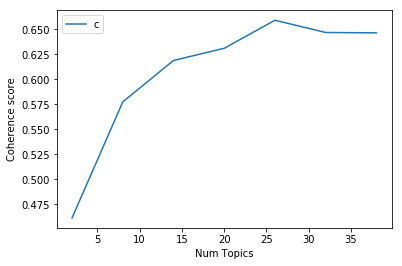

In [11]:
# Show graph
limit=40; start=2; step=6;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [12]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 2  has Coherence Value of 0.4615
Num Topics = 8  has Coherence Value of 0.5774
Num Topics = 14  has Coherence Value of 0.6189
Num Topics = 20  has Coherence Value of 0.631
Num Topics = 26  has Coherence Value of 0.6591
Num Topics = 32  has Coherence Value of 0.6468
Num Topics = 38  has Coherence Value of 0.6465


In [13]:
# Select the model and print the topics
optimal_model = model_list[3]
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=10))

[(0,
  '0.010*"people" + 0.009*"time" + 0.008*"day" + 0.006*"start" + 0.006*"child" '
  '+ 0.006*"happen" + 0.006*"leave" + 0.006*"food" + 0.005*"find" + '
  '0.005*"doctor"'),
 (1,
  '0.039*"people" + 0.019*"make" + 0.019*"write" + 0.014*"good" + '
  '0.014*"article" + 0.010*"thing" + 0.008*"bad" + 0.008*"opinion" + '
  '0.008*"man" + 0.006*"feel"'),
 (2,
  '0.104*"write" + 0.094*"organization" + 0.093*"line" + 0.090*"article" + '
  '0.064*"nntp_post" + 0.056*"host" + 0.051*"university" + 0.031*"reply" + '
  '0.014*"distribution_world" + 0.009*"usa"'),
 (3,
  '0.065*"line" + 0.060*"organization" + 0.025*"university" + '
  '0.018*"nntp_post" + 0.017*"sale" + 0.017*"host" + 0.017*"mail" + '
  '0.016*"price" + 0.015*"sell" + 0.011*"computer"'),
 (4,
  '0.014*"state" + 0.012*"make" + 0.010*"government" + 0.009*"president" + '
  '0.008*"law" + 0.008*"work" + 0.008*"year" + 0.008*"money" + 0.007*"people" '
  '+ 0.007*"american"'),
 (5,
  '0.022*"game" + 0.018*"team" + 0.014*"play" + 0.010*"

In [25]:
def format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    row_print = False
    wp_print = False
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        if not row_print:
            print("row==: ", row)
            row_print = True
        
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                if not wp_print:
                    print("wp----: ", wp)
                    wp_print = True
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=optimal_model, corpus=corpus, texts=data)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Show
df_dominant_topic.head(10)



row==:  [(18, 0.18304093567251462), (2, 0.10701754385964912), (14, 0.05906432748538012), (16, 0.05906432748538012), (0, 0.054385964912280704), (1, 0.052046783625730994), (3, 0.046198830409356725), (6, 0.04035087719298246), (13, 0.038011695906432746), (9, 0.03684210526315789), (12, 0.03567251461988304), (19, 0.03567251461988304), (4, 0.03450292397660819), (11, 0.03450292397660819), (8, 0.03333333333333333), (15, 0.03333333333333333), (5, 0.03216374269005848), (10, 0.02982456140350877), (17, 0.02865497076023392), (7, 0.02631578947368421)]
wp----:  [('car', 0.026782041711735042), ('bike', 0.010679301046601971), ('article', 0.010146097713319419), ('good', 0.008394143903962462), ('write', 0.007937112475434561), ('drive', 0.006733596380311086), ('time', 0.006124221142273884), ('buy', 0.006108986761322954), ('road', 0.005865236666108073), ('line', 0.005773830380402492)]


,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,18.0,0.1830,"car, bike, article, good, write, drive, time, buy, road, line",From: lerxst@wam.umd.edu (where's my thing)\nSubject: WHAT car is this!?\nNntp-Posting-Host: rac...
1,1,15.0,0.1860,"drive, card, problem, system, scsi, driver, mac, work, bit, monitor",From: guykuo@carson.u.washington.edu (Guy Kuo)\nSubject: SI Clock Poll - Final Call\nSummary: Fi...
2,2,18.0,0.3464,"car, bike, article, good, write, drive, time, buy, road, line",From: irwin@cmptrc.lonestar.org (Irwin Arnstein)\nSubject: Re: Recommendation on Duc\nSummary: W...
3,3,8.0,0.3617,"window, run, server, application, set, work, display, program, problem, version",From: tchen@magnus.acs.ohio-state.edu (Tsung-Kun Chen)\nSubject: ** Software forsale (lots) **\n...
4,4,15.0,0.2127,"drive, card, problem, system, scsi, driver, mac, work, bit, monitor","From: dabl2@nlm.nih.gov (Don A.B. Lindbergh)\nSubject: Diamond SS24X, Win 3.1, Mouse cursor\nOrg..."
5,5,18.0,0.4535,"car, bike, article, good, write, drive, time, buy, road, line",From: a207706@moe.dseg.ti.com (Robert Loper)\nSubject: Re: SHO and SC\nNntp-Posting-Host: sun278...
6,6,2.0,0.1474,"write, organization, line, article, nntp_post, host, university, reply, distribution_world, usa",From: kimman@magnus.acs.ohio-state.edu (Kim Richard Man)\nSubject: SyQuest 44M cartrifge FORSALE...
7,7,3.0,0.2006,"line, organization, university, nntp_post, sale, host, mail, price, sell, computer",From: kwilson@casbah.acns.nwu.edu (Kirtley Wilson)\nSubject: Mirosoft Office Package\nArticle-I....
8,8,11.0,0.1619,"god, christian, people, bible, church, man, word, time, life, love",Subject: Re: Don't more innocents die without the death penalty?\nFrom: bobbe@vice.ICO.TEK.COM (...
9,9,17.0,0.3843,"question, exist, reason, claim, evidence, argument, point, write, true, make",From: livesey@solntze.wpd.sgi.com (Jon Livesey)\nSubject: Re: Genocide is Caused by Atheism\nOrg...


In [43]:
# Group top 5 sentences under each topic
sent_topics_sorteddf_mallet = pd.DataFrame()

sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')
#pprint(sent_topics_outdf_grpd['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords'].head(20))

grp_bool = False
for i, grp in sent_topics_outdf_grpd:
    if not grp_bool:
        #print("grp :\n ", grp)
        grp_bool = True
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=[0]).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text"]

# Show
sent_topics_sorteddf_mallet.head(10)

,Topic_Num,Topic_Perc_Contrib,Keywords,Text
0,0.0,0.8012,"people, time, day, start, child, happen, leave, food, find, doctor",From: dbd@urartu.sdpa.org (David Davidian)\nSubject: Accounts of Anti-Armenian Human Rights Viol...
1,1.0,0.5927,"people, make, write, good, article, thing, bad, opinion, man, feel",From: dans@uxa.cso.uiuc.edu (Dan S.)\nSubject: Re: New Study Out On Gay Percentage\nOrganization...
2,2.0,0.3547,"write, organization, line, article, nntp_post, host, university, reply, distribution_world, usa",From: wolfone@ccwf.cc.utexas.edu (I am an android..)\nSubject: Re: ATF BURNS DIVIDIAN RANCH! NO ...
3,3.0,0.5550,"line, organization, university, nntp_post, sale, host, mail, price, sell, computer",From: lusardi@cs.buffalo.edu (Christopher Lusardi)\nSubject: Program Included: 2 Edge Detection ...
4,4.0,0.8484,"state, make, government, president, law, work, year, money, people, american",From: Clinton-HQ@Campaign92.Org (Clinton/Gore '92)\nSubject: CLINTON: Background BRiefing in Van...
5,5.0,0.9272,"game, team, play, player, hockey, win, line, goal, season, good",From: e8l6@jupiter.sun.csd.unb.ca (Rocket)\nSubject: NHL Final point standings\nOrganization: Un...
6,6.0,0.9078,"key, system, encryption, bit, security, chip, government, technology, public, message",From: clipper@csrc.ncsl.nist.gov (Clipper Chip Announcement)\nSubject: text of White House annou...
7,7.0,0.9959,"ax, max, tm, qax, _, mf, giz, ml, wm_wm, gq",Subject: roman.bmp 12/14 \nFrom: pwiseman@salmon.usd.edu (Cliff)\nReply-To: pwiseman@salmon.usd....
8,8.0,0.8041,"window, run, server, application, set, work, display, program, problem, version",From: dbl@visual.com (David B. Lewis)\nSubject: comp.windows.x Frequently Asked Questions (FAQ) ...
9,9.0,0.9642,"file, program, image, graphic, format, line, software, number, entry, package",From: chongo@toad.com (Landon C. Noll)\nSubject: Reposting: 10th International Obfuscated C Code...


In [20]:
# Number of Documents for Each Topic
topic_counts = df_topic_sents_keywords['Dominant_Topic'].value_counts()

# Percentage of Documents for Each Topic
topic_contribution = round(topic_counts/topic_counts.sum(), 4)

# Topic Number and Keywords
topic_num_keywords = df_topic_sents_keywords[['Dominant_Topic', 'Topic_Keywords']]

# Concatenate Column wise
df_dominant_topics = pd.concat([topic_num_keywords, topic_counts, topic_contribution], axis=1)

# Change Column names
df_dominant_topics.columns = ['Dominant_Topic', 'Topic_Keywords', 'Num_Documents', 'Perc_Documents']

# Show
df_dominant_topics

,Dominant_Topic,Topic_Keywords,Num_Documents,Perc_Documents
0,18.0,"car, bike, article, good, write, drive, time, buy, road, line",562.0,0.0497
1,15.0,"drive, card, problem, system, scsi, driver, mac, work, bit, monitor",437.0,0.0386
2,18.0,"car, bike, article, good, write, drive, time, buy, road, line",590.0,0.0521
3,8.0,"window, run, server, application, set, work, display, program, problem, version",854.0,0.0755
4,15.0,"drive, card, problem, system, scsi, driver, mac, work, bit, monitor",387.0,0.0342
5,18.0,"car, bike, article, good, write, drive, time, buy, road, line",590.0,0.0521
6,2.0,"write, organization, line, article, nntp_post, host, university, reply, distribution_world, usa",551.0,0.0487
7,3.0,"line, organization, university, nntp_post, sale, host, mail, price, sell, computer",10.0,0.0009
8,11.0,"god, christian, people, bible, church, man, word, time, life, love",723.0,0.0639
9,17.0,"question, exist, reason, claim, evidence, argument, point, write, true, make",407.0,0.0360
